<a href="https://colab.research.google.com/github/RRustom/3d-ai-playground/blob/master/CLIP_Mesh_Single_Object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP-Mesh

The following notebook is to generate a single object from a text prompt - please check out the [Github Repo](https://github.com/NasirKhalid24/CLIP-Mesh) for more details and checkout the [config](https://github.com/NasirKhalid24/CLIP-Mesh/blob/master/configs/single.yml) for a breakdown for each parameter

Click the play buttons on each cell block or use Runtime > Run All to get started

## Setup

In [ ]:
!git clone --recurse-submodules https://github.com/NasirKhalid24/CLIP-Mesh.git
!cd /content/CLIP-Mesh/; git submodule update --init --recursive

In [ ]:
!cd /content/CLIP-Mesh/; pip install -r requirements.txt

In [ ]:
!cd /content/CLIP-Mesh/loop_limitation/; pip install .

In [ ]:
!cd /content/CLIP-Mesh/DALLE2-pytorch/; pip install .

In [ ]:
!mkdir /content/CLIP-Mesh/weights
!wget https://huggingface.co/spaces/NasirKhalid24/Dalle2-Diffusion-Prior/resolve/main/larger-model.pth -O /content/CLIP-Mesh/weights/model.pth

In [6]:
!python -m pip uninstall matplotlib --y
!pip install matplotlib==3.1.3 mediapy trimesh

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 29.3 MB/s 
     |████████████████████████████████| 659 kB 68.4 MB/s 
     |████████████████████████████████| 1.6 MB 60.9 MB/s 


## Parameters

### Main Parameters

In [19]:
text_prompt = 'a cyberpunk neon blaster gun' #@param {type:"string"}
clip_model = 'ViT-B/32' #@param ["RN50","RN101","RN50x4","RN50x16","RN50x64","ViT-B/32","ViT-B/16","ViT-L/14"]

epochs = 1000 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
batch_size = 25 #@param {type:"integer"}
seed = 99 #@param {type:"integer"}

### Mesh Parameters

In [20]:
# Add meshes here
meshes = [
    '/content/CLIP-Mesh/primitives/sphere.obj',
    # 'path/to/other/mesh'
]

## Unit scale the meshes? (Must be same length as number of mesh in meshes)
unit = [
  True,
]

## What parameters to optimize for each mesh or none at all (vertices, texture map, normal map, true for random texture; false for using defined texture) ? (Must be same length as number of mesh in meshes)
train_mesh_idx = [
  ["verts", "texture", "normal", "true"]
]

## Scale mesh size by some value (Must be same length as number of mesh in meshes)
scales = [
  1.0
]

## After scaling (x, y, z) offset vertices (note that axis are +x, -y, +z) (Must be same length as number of mesh in meshes)
offsets = [
  [0.0, 0.0,  0.0]
]

### Render Parameters

In [21]:
train_res = 356           #@param {type:"integer"}
resize_method = 'cubic'   #@param ["cubic", "linear", "lanczos2", "lanczos3"]
bsdf = 'diffuse'          #@param ["diffuse", "pbr"]
texture_resolution = 512  #@param {type:"integer"}
channels = 4              #@param [3, 4]
init_c = 0.85             #@param {type:"number"}
kernel_size = 7           #@param {type:"integer"}
blur_sigma = 3            #@param {type:"integer"}
shape_imgs_frac = 0.5     #@param {type:"number"}
aug_light = True          #@param {type:"boolean"}
aug_bkg = True            #@param {type:"boolean"}
aug_loc = True            #@param {type:"boolean"}
diff_loss_weight = 0.33   #@param {type:"slider", min:0, max:1, step:0.1}
clip_weight = 1.0         #@param {type:"slider", min:0, max:1, step:0.1}
laplacian_weight = 30.0   #@param {type:"number"}
laplacian_min = 0.6       #@param {type:"number"}
layers = 2                #@param {type:"integer"}

### Camera Parameters

In [24]:
fov_min = 30.0            #@param {type:"number"}
fov_max = 90.0            #@param {type:"number"}
dist_min = 5.0            #@param {type:"number"}
dist_max = 8.0            #@param {type:"number"}
light_power = 5.0         #@param {type:"number"}
elev_alpha = 1.0          #@param {type:"number"}
elev_beta = 5.0           #@param {type:"number"}
elev_max = 60.0           #@param {type:"number"}
azim_min = -360.0         #@param {type:"number"}
azim_max = 360.0          #@param {type:"number"}

### Logging Parameters

In [23]:
log_interval = 5          #@param {type:"integer"}
log_interval_im = 250     #@param {type:"integer"}
log_elev = 30.0           #@param {type:"number"}
log_fov = 60.0            #@param {type:"number"}
log_dist = 8.0            #@param {type:"number"}
log_res = 512             #@param {type:"integer"}
log_light_power = 3.0     #@param {type:"number"}

### Prior Parameters

In [22]:
prior_path =  "/content/CLIP-Mesh/weights/model.pth"          #@param {type:"string"}
# prior_path =                             # Leave empty like this to use only text prompt

## Parameters for diffusion prior network (code by lucidrains)
diffusion_prior_network_dim = 512             #@param {type:"integer"}
diffusion_prior_network_depth = 12            #@param {type:"integer"}
diffusion_prior_network_dim_head = 64         #@param {type:"integer"}
diffusion_prior_network_heads = 12            #@param {type:"integer"}
diffusion_prior_network_normformer = False    #@param {type:"boolean"}

## Parameters for diffusion prior (code by lucidrains)
diffusion_prior_embed_dim = 512                       #@param {type:"integer"}
diffusion_prior_timesteps = 1000                      #@param {type:"integer"}
diffusion_prior_cond_drop_prob = 0.1                  #@param {type:"number"}
diffusion_prior_loss_type = "l2"                      #@param {type:"string"}
diffusion_prior_condition_on_text_encodings = False   #@param {type:"boolean"}

## Use CLIP-Mesh!

### Generate Shape

Result directory '/content/CLIP-Mesh/output/09-25-2022_12-50-27a_cyberpunk_neon_blaster_gun' created
Text is a cyberpunk neon blaster gun


  0%|          | 0/1000 [00:00<?, ?it/s]

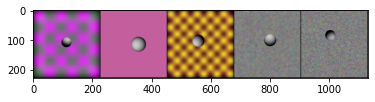

CLIP Loss = -0.252686:  25%|██▌       | 250/1000 [02:15<06:39,  1.88it/s]

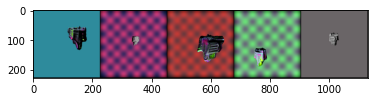

CLIP Loss = -0.273926:  50%|█████     | 500/1000 [04:30<04:23,  1.89it/s]

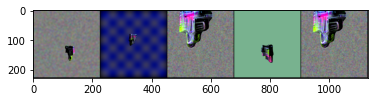

CLIP Loss = -0.325684:  75%|███████▌  | 750/1000 [06:44<02:10,  1.92it/s]

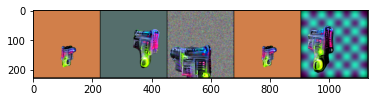

Writing mesh:  /content/CLIP-Mesh/output/09-25-2022_12-50-27a_cyberpunk_neon_blaster_gun/meshes/mesh_0/mesh.obj
    writing 642 vertices
    writing 729 texcoords
    writing 1280 normals
    writing 1280 faces
Writing material:  /content/CLIP-Mesh/output/09-25-2022_12-50-27a_cyberpunk_neon_blaster_gun/meshes/mesh_0/mesh.mtl
Done exporting mesh


In [26]:
import os
import sys
import yaml
import torch
import random
import argparse
import numpy as np

sys.path.append("/content/CLIP-Mesh") 

from loop import loop

# Config validation
cfg = {
    "text_prompt":text_prompt,
    "clip_model":clip_model,
    "epochs":epochs,
    "lr":learning_rate,
    "seed": seed,
    "batch_size":batch_size,
    "meshes":meshes,
    "unit":unit,
    "train_mesh_idx":train_mesh_idx,
    "scales":scales,
    "offsets":offsets,
    "train_mesh_idx":train_mesh_idx,

    "gpu": '0',
    "output_path": '/content/CLIP-Mesh/output/',
    "colab": True,

    "prior_path":prior_path,
    "diffusion_prior_network_dim":diffusion_prior_network_dim,
    "diffusion_prior_network_depth":diffusion_prior_network_depth,
    "diffusion_prior_network_dim_head":diffusion_prior_network_dim_head,
    "diffusion_prior_network_heads":diffusion_prior_network_heads,
    "diffusion_prior_network_normformer":diffusion_prior_network_normformer,

    "diffusion_prior_embed_dim":diffusion_prior_embed_dim,
    "diffusion_prior_timesteps":diffusion_prior_timesteps,
    "diffusion_prior_cond_drop_prob":diffusion_prior_cond_drop_prob,
    "diffusion_prior_loss_type":diffusion_prior_loss_type,
    "diffusion_prior_condition_on_text_encodings":diffusion_prior_condition_on_text_encodings,

    "train_res":train_res,
    "bsdf":bsdf,
    "resize_method":resize_method,
    "texture_resolution":texture_resolution,
    "channels":channels,
    "init_c":init_c,
    "kernel_size":kernel_size,
    "blur_sigma":blur_sigma,
    "shape_imgs_frac":shape_imgs_frac,
    "aug_light":aug_light,
    "aug_bkg":aug_bkg,
    "aug_loc":aug_loc,
    "diff_loss_weight":diff_loss_weight,
    "clip_weight":clip_weight,
    "laplacian_weight":laplacian_weight,
    "laplacian_min":laplacian_min,
    "layers":layers,

    "fov_min":fov_min,
    "fov_max":fov_max,
    "dist_min":dist_min,
    "dist_max":dist_max,
    "light_power":light_power,
    "elev_alpha":elev_alpha,
    "elev_beta":elev_beta,
    "elev_max":elev_max,
    "azim_min":azim_min,
    "azim_max":azim_max,

    "log_interval":log_interval,
    "log_interval_im":log_interval_im,
    "log_elev":log_elev,
    "log_fov":log_fov,
    "log_dist":log_dist,
    "log_res":log_res,
    "log_light_power":log_light_power,
}            


if not( len(cfg["meshes"]) == len(cfg["unit"]) == len(cfg["train_mesh_idx"]) == len(cfg["scales"]) == len(cfg["offsets"])):
    raise("Unit, train_mesh_idx, scales and offsets is not specified for each mesh OR there is an extra item in some list. Ensure all are the same length")

# print(yaml.dump(cfg, default_flow_style=False))

# Set seed
random.seed(cfg["seed"])
os.environ['PYTHONHASHSEED'] = str(cfg["seed"])
np.random.seed(cfg["seed"])
torch.manual_seed(cfg["seed"])
torch.cuda.manual_seed(cfg["seed"])
torch.backends.cudnn.deterministic = True

path = loop(cfg)

### Show Video

In [27]:
import mediapy

mediapy.show_video(mediapy.read_video(os.path.join(path, 'video_log.mp4')), title=cfg["text_prompt"])

### Show Mesh

Download files and load in blender for better viewing experience

This only shows texture and shape

In [28]:
import trimesh
from PIL import Image

m = trimesh.load(os.path.join(path, 'meshes', 'mesh_0', 'mesh.obj'))

im = Image.open(os.path.join(path, 'meshes', 'mesh_0', 'texture_kd.png'))

material = trimesh.visual.texture.SimpleMaterial(image=im)
color_visuals = trimesh.visual.TextureVisuals(uv=m.visual.uv, image=im, material=material)
mesh = trimesh.Trimesh(vertices=m.vertices, faces=m.faces, visual=color_visuals, validate=True, process=False)

In [29]:
mesh.show()

### Download everything

In [30]:
import shutil
from google.colab import files

shutil.make_archive(os.path.join('data'), 'zip', path)

'/content/data.zip'

In [31]:
files.download( '/content/data.zip' )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>